In [10]:
import torch
import torch.nn.functional as F
import random
from IPython import display 
import matplotlib.pyplot as plt

In [11]:
# Get the device
USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    device = torch.cuda.current_device() 
else:
    device = 'cpu'
print(device)

0


In [12]:
# Set the generator
g = torch.Generator().manual_seed(114135)

# Data loading and preprocessing

In [13]:
# Read the dataset
with open('data/names.txt', 'r') as f:
    names_list = f.read().splitlines()

# Get all characters in the name_list
all_chars = sorted(list(set(''.join(names_list))))

# Encoding alphabet using numbering 
# Also using the char '.' to replace the <S> and <E>, the '.' is denoted as 0
stoi = {s:i+1 for i, s in enumerate(all_chars)}
stoi['.'] = 0

# Decoding
itos = {i:s for s, i in stoi.items()}

# Get the number of all_chars list
char_num = len(stoi)

In [14]:
def built_dataset(text, ws, show=False, shuffle=False):
    """ Build the dataset
    text: the raw text
    ws: the number of token for predicting next char
    show: whether show samples in the dataset, default to fault
    """
    X, Y = [], []
    
    if shuffle:
    # Shuffle the x and y
        random.seed(345567)
        random.shuffle(text)

    for t in text:
        # Clean up the window for the next name
        content = [0] * ws

        for c in t + '.':
            X.append(content)
            Y.append(stoi[c])
            content = content[1:] + [stoi[c]]
            if show:
                print(''.join(itos[i] for i in content), '--->', c)

    return torch.tensor(X, device=device), torch.tensor(Y, device=device)

In [15]:
def split_dataset(x, y, tr_rate=0.8, va_rate=0.1):
    assert len(x) == len(y), "The length of two given arrays are not compatiable "

    tr_num = int(tr_rate * len(x))
    va_num = int((tr_rate + va_rate) * len(x))
    
    return x[:tr_num], y[:tr_num], x[tr_num:va_num], y[tr_num:va_num], x[va_num:], y[va_num:]

In [16]:
# The window size = 3, then it use 3 tokens to predict the next chars
window_size = 3
xs, ys = built_dataset(text=names_list, ws=window_size, shuffle=True)
x_tr, y_tr, x_va, y_va, x_te, y_te = split_dataset(xs, ys)
print(x_tr[10:15])
print(y_tr[10:15])

tensor([[19,  9,  5],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 25],
        [19, 25,  2]], device='cuda:0')
tensor([ 0, 19, 25,  2,  5], device='cuda:0')


# Building blocks of the model

In [17]:
class Linear:
    """ The Linear layer defined using same API in Pytorch """

    def __init__(self, in_features, out_features, bias=True, device=None) -> None:
        self.w = torch.randn((in_features, out_features), device=device) / (in_features ** 0.5)
        self.b = torch.zeros(out_features, device=device) if bias else None

    def __call__(self, x):
        self.out = x @ self.w
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.w] + ([] if self.b is None else [self.b])

In [18]:
class BatchNorm1D:
    """ Batch normalization for 1D data """

    def __init__(self, dim, eps=1e-5, momentum=0.1, device=None) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # trainable parameters 
        self.gamma = torch.ones(dim, device=device)
        self.beta = torch.zeros(dim, device=device)

        # buffer (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim, device=device)
        self.running_var = torch.ones(dim, device=device)

    def __call__(self, x):
        # Compute the mean and variance on the batch
        # Along all samples
        if self.training:
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var

        # Update the buffer
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var        
        
        # Normalize and scale as shown in the third and fourth steps in the image to return the result
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps) # Normalize
        self.out = self.gamma * x_hat + self.beta           # Scale 
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [19]:
class Tanh():
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

# Built the network

In [21]:
# Create the look up table, suppose the embedding space is n-dimensional
# then the size of the lookup table is [27, n] (n components for representing each char)
n_emb = 10
n_hidden = 100
lookup = torch.randn((char_num, n_emb), generator=g, device=device)

In [22]:
lookup.shape

torch.Size([27, 10])

In [23]:
# Define the network as a stack of building block
layers = [
    Linear(n_emb * window_size, n_hidden, bias=False, device=device), BatchNorm1D(n_hidden, device=device), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False, device=device), BatchNorm1D(n_hidden, device=device), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False, device=device), BatchNorm1D(n_hidden, device=device), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False, device=device), BatchNorm1D(n_hidden, device=device), Tanh(),
    Linear(           n_hidden, char_num, bias=False, device=device),
]

In [24]:
# Initialize all weights in the network 
with torch.no_grad():
    layers[-1].w *= 0.1 # Less confident in the final layer

    # Initialize all other parameters using Kaiming init 5/3
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.w *= 5/3

In [25]:
# Get all parameters
params = [lookup] + [p for layer in layers for p in layer.parameters()]

# Set all parameters gradient to true
for p in params:
    p.requires_grad = True

n_params = sum(p.nelement() for p in params)
print(f'Total number of parameters {n_params}')

Total number of parameters 36770


# Train the network

In [26]:
# Optimization
steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(steps):

    # Get minibatch from the dataset
    ix = torch.randint(0, x_tr.shape[0], (batch_size,), device=device)
    samples, labels = x_tr[ix], y_tr[ix]

    # Forward pass
    emb = lookup[samples]
    x = emb.view(emb.shape[0], -1) # Concatenate the vectors to maintain the batch number
    for layer in layers:
        x = layer(x)
    
    # Compute the loss using the cross entropy function
    loss = F.cross_entropy(x, labels)

    # Backward
    for layer in layers:
        layer.out.retain_grad()
    for p in params:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 150000 else 0.01
    for p in params:
        p.data += -lr * p.grad
    
    # Track loss and state
    if i % 10000 == 0:
        print(f'{i:7d}/{steps:7d}: Loss={loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr * p.grad).std() / p.data.std()).log10().item() for p in params])

    # if i >= 1000: # For DEBUG
    #     break

      0/ 200000: Loss=3.2982
  10000/ 200000: Loss=2.4349
  20000/ 200000: Loss=2.4441
  30000/ 200000: Loss=1.9101
  40000/ 200000: Loss=2.1472
  50000/ 200000: Loss=2.1761
  60000/ 200000: Loss=2.0083
  70000/ 200000: Loss=1.8071
  80000/ 200000: Loss=1.9378
  90000/ 200000: Loss=2.3398
 100000/ 200000: Loss=2.3605
 110000/ 200000: Loss=2.0840
 120000/ 200000: Loss=2.3257
 130000/ 200000: Loss=2.3067
 140000/ 200000: Loss=2.1288
 150000/ 200000: Loss=1.8893
 160000/ 200000: Loss=2.1588
 170000/ 200000: Loss=1.9998
 180000/ 200000: Loss=2.1008
 190000/ 200000: Loss=2.4023


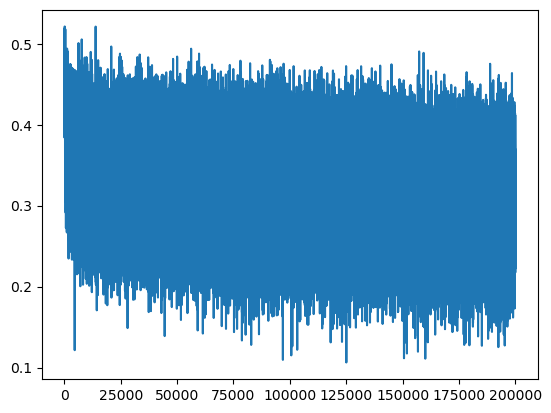

In [27]:
# Show the loss during the training
plt.plot(lossi)

# Save and load the model

In [72]:
# Save parameters
linear_stack = []
bn_gamma_stack = []
bn_beta_stack = []
bn_running_mean_stack = []
bn_running_var_stack = []

for layer in layers:
    if isinstance(layer, Linear):
        linear_stack.append(layer.w)
    if isinstance(layer, BatchNorm1D):
        bn_running_mean_stack.append(layer.running_mean)
        bn_running_var_stack.append(layer.running_var)
        bn_gamma_stack.append(layer.gamma)
        bn_beta_stack.append(layer.beta)
    if isinstance(layer, Tanh):
        continue

torch.save(linear_stack, 'params/wavenet/l_w.pt')
torch.save(bn_running_mean_stack, 'params/wavenet/bn_rm.pt')
torch.save(bn_running_var_stack, 'params/wavenet/bn_rv.pt')
torch.save(bn_gamma_stack, 'params/wavenet/bn_gamma.pt')
torch.save(bn_beta_stack, 'params/wavenet/bn_beta.pt')

In [81]:
# Load the parameters
linear_weights = torch.load('params/wavenet/l_w.pt')
bn_gammas = torch.load('params/wavenet/bn_gamma.pt')
bn_betas = torch.load('params/wavenet/bn_beta.pt')
bn_rm = torch.load('params/wavenet/bn_rm.pt')
bn_rv = torch.load('params/wavenet/bn_rv.pt')

In [82]:
# Define the new model to test
model = [
    Linear(n_emb * window_size, n_hidden, bias=False, device=device), BatchNorm1D(n_hidden, device=device), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False, device=device), BatchNorm1D(n_hidden, device=device), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False, device=device), BatchNorm1D(n_hidden, device=device), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False, device=device), BatchNorm1D(n_hidden, device=device), Tanh(),
    Linear(           n_hidden, char_num, bias=False, device=device),
]

In [83]:
# Assign all parameters to the new defined model
lw_idx = 0
bn_idx = 0
for layer in model:
    if isinstance(layer, Linear):
        layer.w = linear_weights[lw_idx]
        lw_idx += 1
    if isinstance(layer, BatchNorm1D):
        layer.gamma = bn_gammas[bn_idx]
        layer.beta = bn_betas[bn_idx]
        layer.running_mean = bn_rm[bn_idx]
        layer.running_var = bn_rv[bn_idx]
        bn_idx += 1
    if isinstance(layer, Tanh):
        continue

# Loss on the Test and Validate set

In [90]:
@torch.no_grad()
def compute_loss(dataset):
    # Get the select dataset for loss computation
    x, y = {'train': (x_tr, y_tr), 'valid': (x_va, y_va), 'test': (x_te, y_te)}[dataset]

    # Forward pass to the model to get prediction
    emb = lookup[x]
    x_preds = emb.view(emb.shape[0], -1)
    for layer in model:
        x_preds = layer(x_preds)

    # Compute the loss
    loss = F.cross_entropy(x_preds, y)
    print(f'Loss on {dataset}-set is {loss.item():.4f}')

In [92]:
for layer in model:
    layer.training = False # put layers into eval mode

In [94]:
compute_loss('train')
compute_loss('valid')
compute_loss('test')

Loss on train-set is 2.0120
Loss on valid-set is 2.0940
Loss on test-set is 2.0829


# Generate new names

In [97]:
# sample from the model
g = torch.Generator(device=device).manual_seed(2147483647 + 10)

In [101]:
for _ in range(20):
    names = []

    context = [0] * window_size
    while True:
        # Again, forward pass to the model
        emb = lookup[torch.tensor([context], device=device)]
        x_preds = emb.view(emb.shape[0], -1)
        for layer in model:
            x_preds = layer(x_preds)
        
        # Get the char with the maximum possibility (maximum likelihood)
        logits = x_preds
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        
        # Get the new and next combinations for prediction
        # Break when meets the '.', or say 0 in the index list
        if ix != 0:
            context = context[1:] + [ix]
            names.append(ix)
        else:
            break

    print(''.join(itos[i] for i in names))

faton
tolyn
jaylee
jose
harb
kai
ruenay
gurias
sjrah
elicie
ger
anwenleill
rael
sharson
zamaileah
dajykanynslee
loulle
tyjahman
malazaelayden
coberta
